# Stock prediciton based on random walks using true random numbers

In order to estimate the variance and risk of a stock over time, the price deveolpment can be modelled by random walks. In the case of a symmetric walk, there is a 50% probability for either a growing or falling stpck price by a certain amount per day. By doing multiple repetitions of the simulation fpr a given period of time, one can estimate the variance of the stock. In order to ensure a true random walk, random numbers will be generated by a quantum computer. Like this, true randomness of the numbers making up the behaviour of the walk is ensured and no deterministically working classical algorithms contributes to the trend. True randomness of the input is also a desirable property for fields like encryption and communication.

In [1]:
#import requests
#import base64
import json

In [2]:
# define sample size, time frame and possible scenarios for the grow/fall rate of the stock
n_stocks = 20
n_days = 200
n_bits = 1

## Define input for service execution

In [3]:
n_numbers = n_stocks*n_days
backend_string = 'qasm_simulator'

data = {
    "n_numbers": n_numbers
}

params = {
    "n_bits": n_bits,
    "backend": backend_string
}

input_json = json.dumps({
    "data": data,
    "params": params
})

## Local Service Execution

Executes local service within `src` module

In [8]:
from loguru import logger
from src.program import run

# disable logs from logger in src
logger.disable("src")

# enable logs from logger in src
# logger.enable("src")

In [16]:
result = run(data, params)
rng_list = result.result['random_number_list']

## Post Processing

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
if n_bits == 1:
    # symmetric growth/shrink rates of 1%
    growth_rates = [0.01]
    shrink_rates = [0.01]
if n_bits == 2:
    # introduce different, yet equally likely rates
    growth_rates = [0.01, 0.02]
    shrink_rates = [0.005, 0.021]

half_range = 2**(n_bits-1)
whole_range = 2*half_range

if len(growth_rates) != half_range or len(shrink_rates) != half_range:
    print("## Rates do not match the chosen range.##")
    print("## Setting rates linear in 1% steps")
    growth_rates = [0.01*i for i in range(1, half_range+1)]
    shrink_rates = growth_rates.copy()
    
mean_rate = sum([pos_rate - neg_rate for pos_rate, neg_rate in zip(growth_rates, shrink_rates)])/(2*len(growth_rates))

In [19]:
start_price = 100.0

for i in range(n_stocks):
    start_idx = i * n_days
    end_idx = start_idx + n_days

    cf = pd.DataFrame({"rng": rng_list[start_idx:end_idx]})
    cf["factor"] = cf["rng"]
    
    for idx in range(half_range):
        cf.loc[cf["factor"] == idx, "factor"] = 1 - shrink_rates[idx]
        cf.loc[cf["factor"] == idx + half_range, "factor"] = 1 + growth_rates[idx]
    
    
    cf["factor"] = cf["factor"].cumprod()
    cf["price"] = start_price * cf["factor"]
    cf["stock"] = i
    cf["day"] = range(1, n_days + 1)

    if start_idx == 0:
        df = cf
    else:
        df = pd.concat([df, cf], axis = 0, ignore_index=False)
    df.reset_index(drop=True)

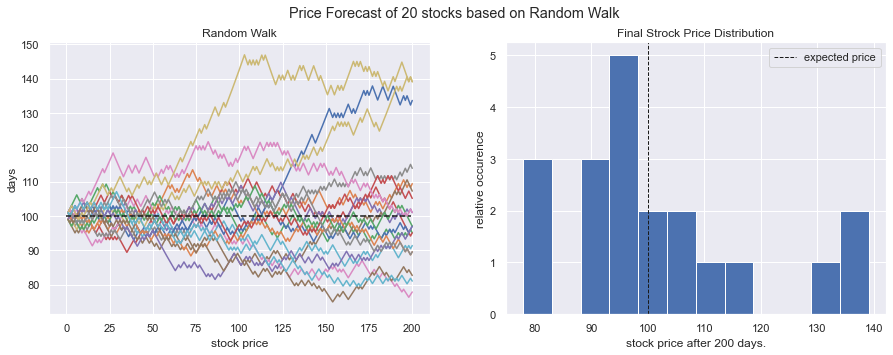

In [21]:
# Plot series
sns.set_theme()
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].set_xlabel("stock price")
ax[0].set_ylabel("days")
ax[0].set_title('Random Walk')

fig.suptitle(f"Price Forecast of {n_stocks} stocks based on Random Walk")

# random walk visualization
for i in range(n_days):
    sf = df[df["stock"] == i]
    ax[0].plot(sf["day"], sf["price"], "-", label='_nolegend_')
mean_prices = [start_price*(1+mean_rate)**day_idx for day_idx in range(n_days)]
ax[0].plot(range(n_days), mean_prices, "--k")

# final prices distribution
last_day_prices = df[df['day']==n_days]['price']
ax[1].hist(last_day_prices, bins=int((max(last_day_prices)-min(last_day_prices))//5))
ax[1].axvline(mean_prices[-1], color = 'k', linestyle = 'dashed', linewidth=1, label = '1')

ax[1].set_title(f"Final Strock Price Distribution")
ax[1].set_xlabel(f"stock price after {n_days} days.")
ax[1].set_ylabel(f"relative occurence")

ax[1].legend(["expected price"])
plt.show()